# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [3]:
%autosave 180
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Autosaving every 180 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [4]:
env = gym.make('Blackjack-v1')

/home/cat/miniconda3/envs/rl/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/cat/miniconda3/envs/rl/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [5]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [6]:
##########################################
##########################################
##########################################
for i_episode in range(3):
    state = env.reset()
    while True:
        print("state: ", state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

state:  (17, 5, False)
End game! Reward:  -1.0
You lost :(

state:  (12, 10, False)
End game! Reward:  -1.0
You lost :(

state:  (15, 10, False)
End game! Reward:  -1.0
You lost :(



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [7]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [8]:
######################################################################
######################################################################
######################################################################
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((19, 1, False), 0, -1.0)]
[((12, 1, False), 1, -1.0)]
[((13, 6, False), 1, -1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [9]:
######################################################################
######################################################################
######################################################################
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    from tqdm import trange
    for i_episode in trange(1, num_episodes+1):
        # monitor progress
        #if i_episode % 1 == 0:
        #print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
        sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode_from_limit_stochastic(env)
        #print ("episode: ", episode)
        
        #
        states, actions, rewards = zip(*episode)
        
        #
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        #
        for i, state in enumerate(states):
            #print ('state: ', state)
            #print ("rewards: ", rewards[i:])
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            
            # why are we computing Q every loop? 
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
  #print ("")
    #print ("FINAL Q: ", Q)
    print ("")
        
    #
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

In [15]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# make dictionary with the state "k" and the 
#for k, v in Q.items():
#    V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))))

#print ("V: ", V_to_plot)
    
# plot the state-value function
plot_blackjack_values(V_to_plot)

 13%|███████▍                                                   | 63039/500000 [00:51<05:57, 1222.05it/s]


KeyboardInterrupt: 

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [12]:
#########################################################
################## HELPER FUNCTIONS #####################
#########################################################
def generate_episode_from_Q(env, 
                            Q, 
                            epsilon, 
                            nA): # nA is just the # of action space states, i.e. 4 in our grid world gym
    
    """ generates an episode from following the epsilon-greedy policy 
    
        Input: - enviorment
               - Q: policy
               - epsilon: exploration probability parameter
               - nA: number of states
    
    """
    episode = []
    state = env.reset()
    while True:
        
        # if the current state previously visited,
        # then take the best option subject to epsilon greedy probability
        if state in Q:
            action = np.random.choice(np.arange(nA),          # 0,1,2,3 <- the possible states
                                      p=get_probs(Q[state],   # e.g. 0.1, 0.1, 0.9, 0.1   <- as epsilon decreases
                                                  epsilon,    # so, over time, we select 0-3 with probability distribution
                                                      nA)     # highly biased to the highest action
                                     )                        # i.e. our action-value function
            
        # current state not visited before, so we sample actions randomly
        # (or based on the .sample() method of the gym
        else:
            action = env.action_space.sample()
        
        # compute next state, reward, etc from our gym
        #  and see if we reached an end state
        next_state, reward, done, info = env.step(action)
        
        #
        episode.append((state, action, reward))
        
        #
        state = next_state
        
        #
        if done:
            break
            
    #
    return episode

#
def get_probs(Q_s, 
              epsilon, 
              nA):
    
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)   # this return an array of values increasinbly biased to 
                                                      # hight action based on Q
                                                      # eg., early: 0.25, 0.25, 0.25, 0.25
                                                      #      later: 0.1, 0.1, 0.9, 0.1  Q: why don't thse add up to 1?
    
    #
    return policy_s

#
def update_Q(env, 
             episode, 
             Q, 
             alpha, 
             gamma):
    
    """ updates the action-value function estimate using the most recent episode """
    
    # unwrap the states from an episode
    states, actions, rewards = zip(*episode)
    
    # prepare for discounting; again depending on the length of the episode, need to scale future rewards by gamma
    # here 1.0 though
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    # enumerate over each state in the episode
    # and update the Q[s][a] by adding some alpha discounted value to 
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 

        # review this function again;
        # seems we update by some small amount alpha (that doesn't decay)
        #    times the new reward - old reward
        # Not completely clear how this works
        #  mostly likely: we are adding value to each of the possible actions;
        #   but the best directoin will generally grow faster than the other ones
        #   given that it's sampled enough...
        # So, VERY INTERESTING, there is no gradient descent on the error etc. required
        #  - the algorithm essentially slowly finds the most correct action-state pairing by averating
        #    over many such states
        #  - seems very inefficient; heuristics would probably help a lot [is there literature on this!?]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)

        
    #
    return Q

In [13]:
#########################################################
##################### LEARN POLICY ######################
#########################################################
def mc_control(env, 
               
               num_episodes, 
               
               alpha,                       # alpha is scaler which scales the reward error (new reward-expected reward)
                                            #   to a fixed value, rather than dividing by N-# of samples/episodes
               
               gamma=1.0, 
               
               eps_start=1.0,               # epsilon greedy policy: controls how often we choose a randoma ction
                                            #  we start with random action selection;
                                            #  over time we decrease the eps value to increasingly select the most optimal action 
               
               eps_decay=.99999, 
               
               eps_min=0.05):
    
    # number of states
    nA = env.action_space.n
    
    #
    epsilon = eps_start

    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    # loop over episodes
    from tqdm import trange
    for i_episode in trange(1, num_episodes+1):
        # monitor progress
        #if i_episode % 1000 == 0:
        #    print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
        #    sys.stdout.flush()
        
        # set the value of epsilon;
        # epsilon starts at 1.0 and decays by 0.99999 every episode;
        epsilon = max(epsilon*eps_decay, eps_min)
        
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, 
                                          Q, 
                                          epsilon, 
                                          nA)
        
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)

    # determine the policy corresponding to the final action-value function estimate
    # so for each location k, find the maximum/most often employed action
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    
    #
    return policy, Q


Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [16]:
# obtain the estimated optimal policy and action-value function
alpha = 0.2
n_episodes = 500000
policy, Q = mc_control(env, n_episodes, alpha)

#


100%|██████████████████████████████████████████████████████████| 500000/500000 [03:33<00:00, 2346.21it/s]


Next, we plot the corresponding state-value function.

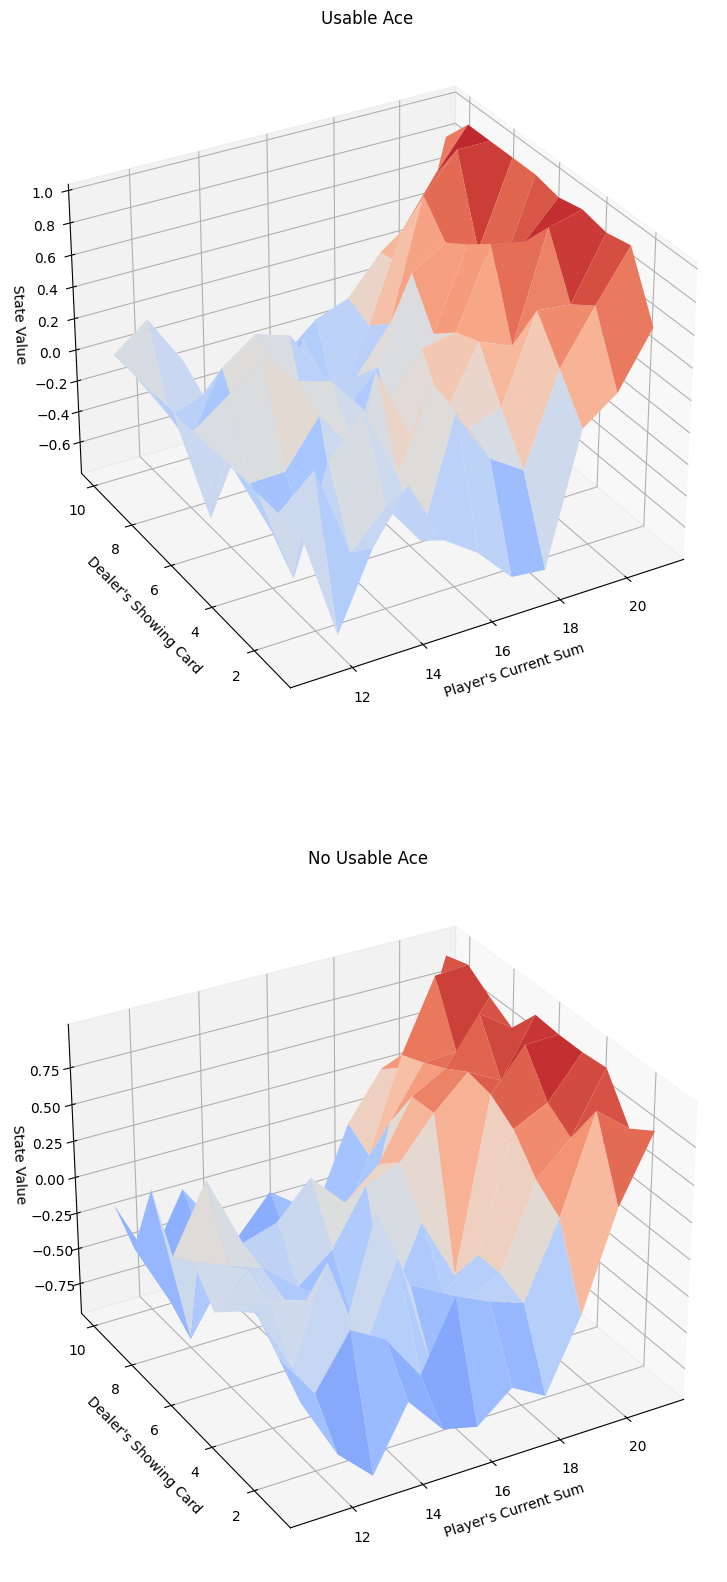

In [14]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

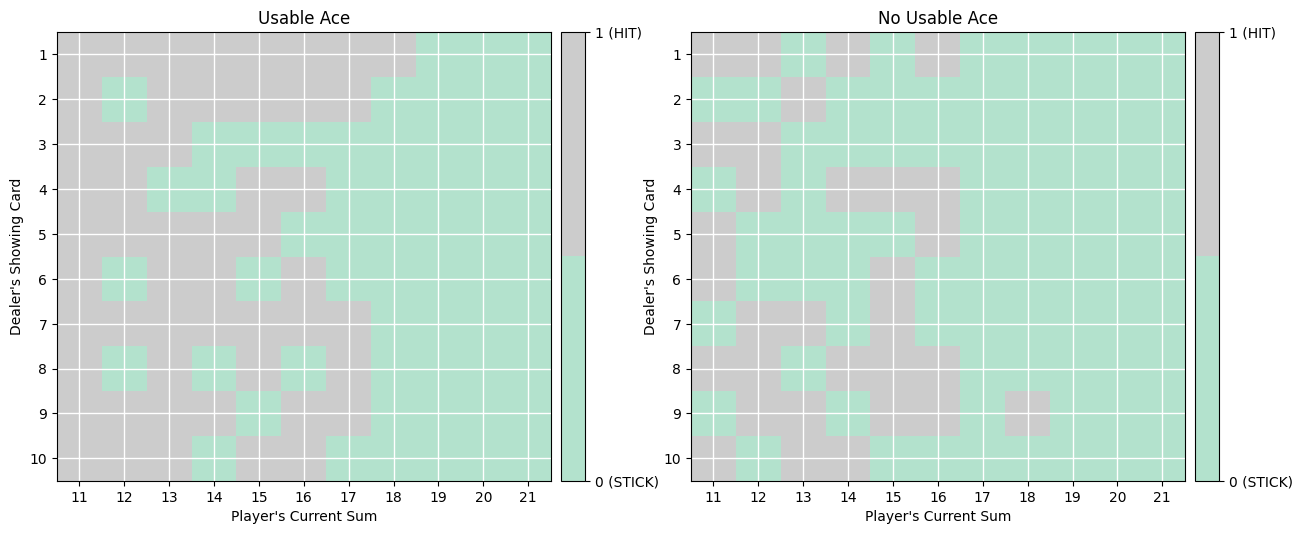

In [29]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)